3.	Необходимо написать на базе BERT определитель жанра фильма: 
a.	На вход подается сюжет фильма. На выходе - жанр 
sample: https://www.kaggle.com/balraj98/movie-genre-prediction-from-wiki-plot-using-bert 

<h1><center>Movie Genre Prediction from Wiki Movie Plots</center></h1>

# Introduction

#### In this notebook, we use [BERT](https://arxiv.org/abs/1810.04805) Transformer model to predict movie genres from wikipedia movie plots

## Libraries 📚⬇

In [1]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
%%time

!pip uninstall -q torch -y
!pip install -q torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q -U tokenizers==0.7.0 > /dev/null
!pip install -q -U transformers==3.0.2 > /dev/null
!pip install -q -U simpletransformers==0.46.0 > /dev/null

In [2]:
import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__

('1.12.1+cpu', '4.21.1', '0.12.1')

### Read CSV Data 📝

In [3]:
movies_df = pd.read_csv("wiki_movie_plots_deduped.csv")
movies_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Data Pre-processing ⚙️

In [4]:
movies_df = movies_df[(movies_df["Origin/Ethnicity"]=="American") | (movies_df["Origin/Ethnicity"]=="British")]
movies_df = movies_df[["Plot", "Genre"]]
drop_indices = movies_df[movies_df["Genre"] == "unknown" ].index
movies_df.drop(drop_indices, inplace=True)

# Combine genres: 1) "sci-fi" with "science fiction" &  2) "romantic comedy" with "romance"
movies_df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)

# Choosing movie genres based on their frequency
shortlisted_genres = movies_df["Genre"].value_counts().reset_index(name="count").query("count > 200")["index"].tolist()
movies_df = movies_df[movies_df["Genre"].isin(shortlisted_genres)].reset_index(drop=True)

# Shuffle DataFrame
movies_df = movies_df.sample(frac=1).reset_index(drop=True)

# Sample roughly equal number of movie plots from different genres (to reduce class imbalance issues)
movies_df = movies_df.groupby("Genre").head(400).reset_index(drop=True)

label_encoder = LabelEncoder()
movies_df["genre_encoded"] = label_encoder.fit_transform(movies_df["Genre"].tolist())

movies_df = movies_df[["Plot", "Genre", "genre_encoded"]]
movies_df

,Plot,Genre,genre_encoded
0,The story begins with exposition of the diffic...,drama,6
1,"During the siege at the Alamo, John Stroud (Gl...",western,15
2,"Sir Charles Hare (Terence Morgan), a dissolute...",comedy,3
3,Chuck Stephens is fooled by his sailor pals Sw...,comedy,3
4,"While at West Point, Bob Denton rebuffs Evelyn...",drama,6
...,...,...,...
5933,Steve Boland (Charles Bronson) is a cynical mi...,war,14
5934,Assigned to bomb a critical German railway jun...,war,14
5935,"The publisher of The Tribune newspaper, Henry ...",mystery,10
5936,"A few hours before D-Day, Special Force Six em...",war,14


## BERT Training & Evaluation 🚞

In [5]:
%%time

from simpletransformers.classification import ClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
}

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=len(shortlisted_genres), args=model_args, use_cuda=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

CPU times: total: 3.48 s
Wall time: 8.04 s


In [6]:
%%time

train_df, eval_df = train_test_split(movies_df, test_size=0.2, stratify=movies_df["Genre"], random_state=42)

# Train the model
model.train_model(train_df[["Plot", "genre_encoded"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["Plot", "genre_encoded"]])
print(result)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4750 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_512_16_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/297 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/297 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/297 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/297 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1188 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_512_16_2


Running Evaluation:   0%|          | 0/149 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5387296237435334, 'eval_loss': 1.3980516397312983}


{'mcc': 0.5387296237435334, 'eval_loss': 1.3980516397312983}
CPU times: total: 1d 16h 27min 54s
Wall time: 7h 7min 33s


## Plot Heatmap 📉

### Heatmap (w. labels & annotations)

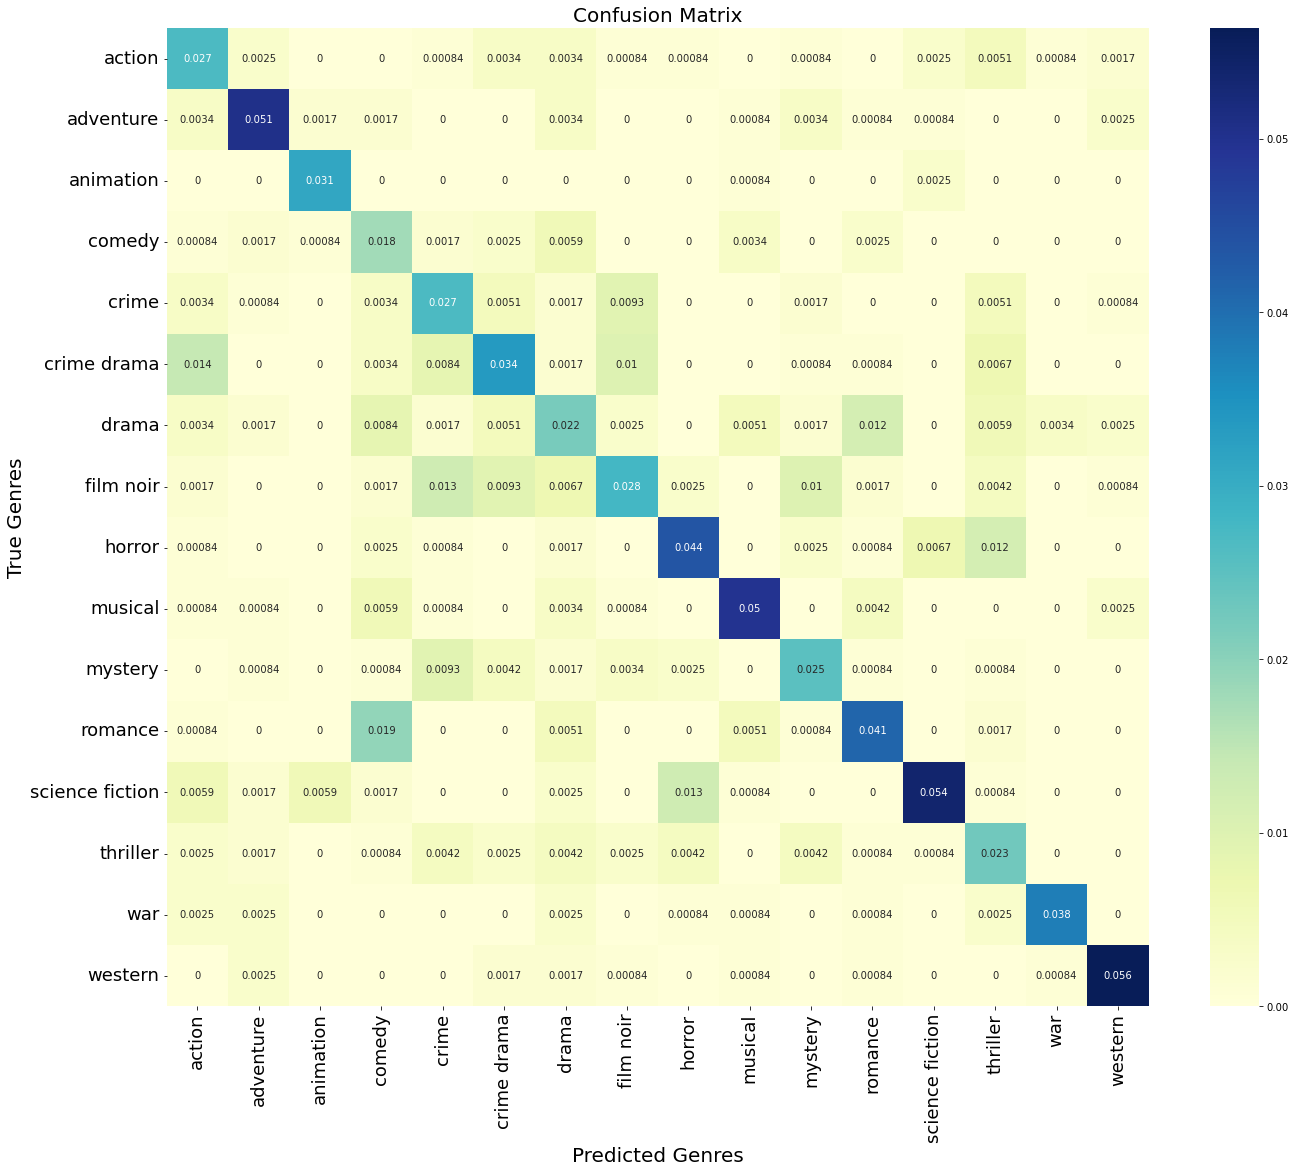

In [7]:
predicted_genres_encoded = list(map(lambda x: np.argmax(x), model_outputs))
predicted_genres = list(label_encoder.inverse_transform(predicted_genres_encoded))
eval_gt_labels = eval_df["Genre"].tolist()
class_labels = list(label_encoder.classes_)

plt.figure(figsize=(22,18))
# cf_matrix = confusion_matrix(predicted_genres, eval_gt_labels, class_labels)
cf_matrix = confusion_matrix(predicted_genres, eval_gt_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted Genres', fontsize=20)
ax.set_ylabel('True Genres', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_labels, rotation=90, fontsize=18)
ax.set_yticklabels(class_labels, rotation=0, fontsize=18)

plt.show()

## Prediction 🔮

In [9]:
x = 100
Pr = 0
for _ in range(x):

    random_idx = random.randint(0, len(eval_df)-1)
    text = eval_df.iloc[random_idx]['Plot']
    true_genre = eval_df.iloc[random_idx]['Genre']

    # Predict with trained multiclass classification model
    predicted_genre_encoded, raw_outputs = model.predict([text])
    predicted_genre_encoded = np.array(predicted_genre_encoded)
    predicted_genre = label_encoder.inverse_transform(predicted_genre_encoded)[0]

    print(f'\nTrue Genre:'.ljust(16,' '), f'{true_genre}\n')
    print(f'Predicted Genre: {predicted_genre}\n')
    # print(f'Plot: {text}\n')
    print("-------------------------------------------")
    if true_genre == predicted_genre :
        Pr += 1

print(f'количество тестов - {x}, из них предсказание верно в {Pr} случаях')


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     science fiction

Predicted Genre: science fiction

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     action

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     romance

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     mystery

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime

Predicted Genre: mystery

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: musical

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     romance

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: thriller

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: film noir

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: horror

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     science fiction

Predicted Genre: science fiction

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     romance

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     science fiction

Predicted Genre: science fiction

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     western

Predicted Genre: western

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     action

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     romance

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: horror

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: thriller

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     action

Predicted Genre: action

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     mystery

Predicted Genre: mystery

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     western

Predicted Genre: crime

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: thriller

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     horror

Predicted Genre: mystery

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: film noir

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     western

Predicted Genre: western

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     drama

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: film noir

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     drama

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     mystery

Predicted Genre: thriller

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: film noir

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     western

Predicted Genre: western

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     action

Predicted Genre: comedy

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: war

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: mystery

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     romance

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: action

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     war

Predicted Genre: war

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     musical

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     romance

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     thriller

Predicted Genre: thriller

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     mystery

Predicted Genre: mystery

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     western

Predicted Genre: western

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     war

Predicted Genre: war

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: crime

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: film noir

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: thriller

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     western

Predicted Genre: western

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     musical

Predicted Genre: musical

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime

Predicted Genre: film noir

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     comedy

Predicted Genre: crime

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     romance

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     western

Predicted Genre: western

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     animation

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     musical

Predicted Genre: musical

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     war

Predicted Genre: action

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     horror

Predicted Genre: horror

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     musical

Predicted Genre: musical

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     western

Predicted Genre: western

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     drama

Predicted Genre: musical

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     mystery

Predicted Genre: mystery

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     action

Predicted Genre: action

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     drama

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     drama

Predicted Genre: western

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     action

Predicted Genre: action

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     adventure

Predicted Genre: adventure

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     musical

Predicted Genre: romance

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     animation

Predicted Genre: science fiction

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime

Predicted Genre: mystery

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     crime drama

Predicted Genre: crime drama

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     film noir

Predicted Genre: film noir

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


True Genre:     science fiction

Predicted Genre: science fiction

-------------------------------------------
количество тестов - 100, из них предсказание верно в 52 случаях


In [ ]:
for _ in range(5):

    random_idx = random.randint(0, len(eval_df)-1)
    text = eval_df.iloc[random_idx]['Plot']
    true_genre = eval_df.iloc[random_idx]['Genre']

    # Predict with trained multiclass classification model
    predicted_genre_encoded, raw_outputs = model.predict([text])
    predicted_genre_encoded = np.array(predicted_genre_encoded)
    predicted_genre = label_encoder.inverse_transform(predicted_genre_encoded)[0]

    print(f'\nTrue Genre:'.ljust(16,' '), f'{true_genre}\n')
    print(f'Predicted Genre: {predicted_genre}\n')
    print(f'Plot: {text}\n')
    print("-------------------------------------------")